In [130]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, zero_one_loss

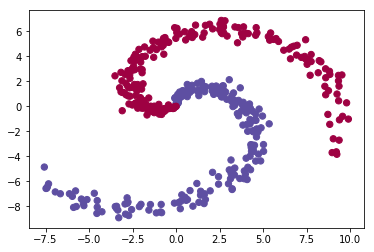

In [2]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes
X = np.zeros((N*K,D))# data matrix (each row = single example)

#Creates targets
y = np.ones(N,dtype=np.int)
minus = -1 * np.ones(N,dtype=np.int)
y = np.append(y,minus)

#Generates the samples
np.random.seed(42)
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,10,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    #y[ix] = j

#Splits data in train/test-sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

#Lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [143]:

np.shape(y_train)
y_train[:5]

array([-1, -1, -1,  1,  1])

In [159]:
class NeuralNet():
    def __init__(self, inputs, no_nodes1, no_nodes2, eta):
        self.no_nodes_first_layer = no_nodes1
        self.no_nodes_second_layer = no_nodes2  
        self.no_input_nodes = inputs
        self.eta = eta
        
        self.number_of_layers = 2
        
    def phi_function(self, x):
        return (2 / (1 + np.exp(-x))) - 1
    
    def phi_prime(self, x):
        return (1 + self.phi_function(x))*(1 - self.phi_function(x)) / 2
    
    def init_weights(self, no_inputs, no_neurons):
        return np.random.normal(0, 1, size=(no_inputs + 1, no_neurons))
    
    def forward_pass(self, v, w, x):
        bias = np.ones([1, len(x)])
        x = np.column_stack([x, bias.T])
        
        hin = np.dot(x, w)
        hout = self.phi_function(hin)
        hout = np.column_stack([hout, bias.T])
        
        oin = np.dot(hout, v)
        oout = self.phi_function(oin)
        
        return (hout, oout, oin)
    
    def backprop(self, v, t, oin, oout, hout):
        t = np.expand_dims(t,1)
    
        delta_o = np.multiply((oout - t), self.phi_prime(oout))
       
        delta_h = np.dot(delta_o, v.T) * self.phi_prime(hout)
        delta_h = delta_h[:, :self.no_nodes_first_layer]
        return delta_h, delta_o
    
    def weight_update(self, x, hout, v, w, dv, dw, delta_h, delta_o):
        alpha = 0.9
        
        bias = np.ones(len(x))
        x = np.column_stack([x, bias.T])
      
        dw = (dw * alpha) - np.array(np.dot(x.T, delta_h)) * (1-alpha)

        dv = (dv * alpha) - np.array(np.dot(hout.T, delta_o)) * (1-alpha)
        w = w + dw * self.eta
        v = v + dv * self.eta 
        return (v, w, dw, dv)
      
    def test_accuracy(self, predictions, targets):
        # mean squared error
        mse = mean_squared_error(targets, predictions)
        
        # accuracy
        for i in range(len(predictions)):
            if predictions[i] >= 0:
                predictions[i] = 1
            else:
                predictions[i] = -1
        acc = zero_one_loss(targets, predictions, normalize=True)
        
        return mse, acc
        
    def batch_learn(self, x_train, y_train, x_test, y_test, epochs):
        w = self.init_weights(self.no_input_nodes, self.no_nodes_first_layer)
        v = self.init_weights(self.no_nodes_first_layer, self.no_nodes_second_layer)
        dw = 0
        dv= 0
        
        for i in range(epochs):
            hout, oout, oin = self.forward_pass(v, w, x_train)
            delta_h, delta_o = self.backprop(v, y_train, oin, oout, hout)
            v, w, dw, dv = self.weight_update(x_train, hout, v, w, dv, dw, delta_h, delta_o)
            
            _, train_predictions, _ = self.forward_pass(v, w, x_train)
            train_mse, acc = self.test_accuracy(train_predictions, y_train)
            #print("train_predictions:", train_predictions[:5, :])
            print("train_mse:", train_mse)
            print("acc", acc)
            
        print("w:", w)
        print("v:", v)
        
        

In [161]:
n = NeuralNet(2, 3, 1, 0.01)

n.batch_learn(X_train, y_train, X_test, y_test, 20)


train_mse: 1.1160024086293614
acc 0.51
train_mse: 1.0022622629195534
acc 0.51
train_mse: 0.8813367432412478
acc 0.29666666666666663
train_mse: 0.7913893575338691
acc 0.21333333333333337
train_mse: 0.7431526301634871
acc 0.29000000000000004
train_mse: 0.7355766318601523
acc 0.30666666666666664
train_mse: 0.7565957531658699
acc 0.31000000000000005
train_mse: 0.7903637587280989
acc 0.32666666666666666
train_mse: 0.825893331169425
acc 0.33333333333333337
train_mse: 0.8569521525472048
acc 0.33333333333333337
train_mse: 0.8795097495767675
acc 0.3466666666666667
train_mse: 0.8913193712236658
acc 0.33999999999999997
train_mse: 0.8914711620887957
acc 0.33333333333333337
train_mse: 0.8809361365360576
acc 0.32666666666666666
train_mse: 0.86266681019287
acc 0.31999999999999995
train_mse: 0.8405156774687897
acc 0.31333333333333335
train_mse: 0.8181310390531098
acc 0.31666666666666665
train_mse: 0.7978705122449761
acc 0.31666666666666665
train_mse: 0.7800217769403606
acc 0.31333333333333335
train_ms